# Comparison of Single Search Algorithm

In this notebook, I compare different **Single-Search Algorithms** for solving the Traveling Salesman Problem (TSP). Single Search Algorithms, as opposed to population-based methods, focus on exploring and refining a single candidate solution at a time. These methods rely heavily on the quality of their local search and neighborhood exploration strategies to optimize the solution.

The algorithms considered include:
1. **Hill Climber**
     - Stochastic Hill Climbing: A probabilistic approach to improve the solution by exploring random neighbors.
     - Steepest Hill Climbing: A deterministic strategy that always moves to the best neighbor.
     - Iterated Local Search: Combines local optimization with heuristic perturbations to escape local optima.
2. **Tabu Search**: Uses memory structures to prevent revisiting recently explored solutions.
3. **Simulated Annealing**: Balances exploration and exploitation by probabilistically accepting worse solutions to escape local optima.

The goal is to evaluate these algorithms based on key metrics such as best distance, average distance, and standard deviation across multiple runs. After this evaluation, I will select a specific Single Search algorithm for further comparison with population-based algorithms, such as the Genetic Algorithm.

This notebook provides an in-depth comparison, focusing on the strengths and weaknesses of each approach and their suitability for TSP instances with complex solution landscapes.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import random
import time
import math


## Data Preperation

The following code block loads the city data from a CSV file named `cities.csv`. It then extracts the city names and their corresponding coordinates. Finally, it calculates the Euclidean distance matrix, which stores the distances between all pairs of cities. This distance matrix is crucial for evaluating the length of different routes.

In [28]:
# Load data from the CSV file.
data = pd.read_csv('cities.csv')

# Extract city names and coordinates.
cities = data['City'].values
coordinates = data[['X', 'Y']].values

# Calculate the Euclidean distance matrix between all pairs of cities.
dist_matrix = cdist(coordinates, coordinates, 'euclidean') 

average_values = [
    ['Stochastic Hill Climbing', 'Steepest Hill Climbing', 'Iterated Local Search', 'Tabu Search', 'Simulated Annealing'],
    [],
    [],
    []
]


These functions help visualize the cities and the routes generated by the algorithms.

*  `visualize_raw_cities(cities_cord)`: This function creates a scatter plot to display the locations of the cities. This provides an initial overview of the spatial distribution of the cities.

*  `plot_route_with_labels(route, coordinates, city_names, title="Route")`: This function plots a given route on a graph, connecting the cities in the order they are visited. It also adds labels to the cities and arrows to indicate the direction of travel. This visualization helps in understanding the paths generated by the SA and GA algorithms.

In [29]:
def visualize_raw_cities(cities_cord):
    """
    Visualizes the raw city coordinates on a scatter plot.

    Args:
      cities_cord: A list of tuples, where each tuple represents the (x, y) 
                   coordinates of a city.
    """
    plt.figure(figsize=(10, 6))  # Creates a figure with a specific size
    
    # Plots a scatter plot of city coordinates.
    plt.scatter([city[0] for city in cities_cord], 
                [city[1] for city in cities_cord], 
                color='red')  
    
    plt.show()  # Displays the plot


def plot_route_with_labels(route, coordinates, city_names, title="Route"):
    """
    Plots a given route on a graph with city labels and arrows indicating 
    the direction of travel.

    Args:
      route: A list of integers representing the sequence of cities in the route.
      coordinates: A NumPy array of city coordinates.
      city_names: A list of city names corresponding to the coordinates.
      title: (Optional) The title of the plot. Defaults to "Route".
    """
    # Reorder coordinates and city names according to the route.
    route_coords = coordinates[route + [route[0]]]  # Add the starting city at the end for a closed loop
    route_names = [city_names[i] for i in route] + [city_names[route[0]]]

    plt.figure(figsize=(12, 8))

    # Plot the route with arrows.
    for i in range(len(route_coords) - 1):
        plt.plot(
            [route_coords[i][0], route_coords[i + 1][0]],
            [route_coords[i][1], route_coords[i + 1][1]],
            'o-', markersize=8, color='blue'
        )

        # Add an arrow to indicate direction.
        plt.arrow(
            route_coords[i][0], route_coords[i][1],
            route_coords[i + 1][0] - route_coords[i][0],
            route_coords[i + 1][1] - route_coords[i][1],
            head_width=0.5, head_length=0.5, fc='blue', ec='blue'
        )

        # Label the city with its name and sequence number.
        plt.text(
            route_coords[i][0], route_coords[i][1],
            f"{route_names[i]} ({i + 1})", color='black',
            fontsize=9, ha='center'
        )

    # Label the final city (which is also the starting city).
    plt.text(
        route_coords[-1][0], route_coords[-1][1],
        f"{route_names[-1]} (Start)", color='black',
        fontsize=9, ha='center'
    )
    
    # Add plot title, labels, and grid.
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid()
    plt.show()

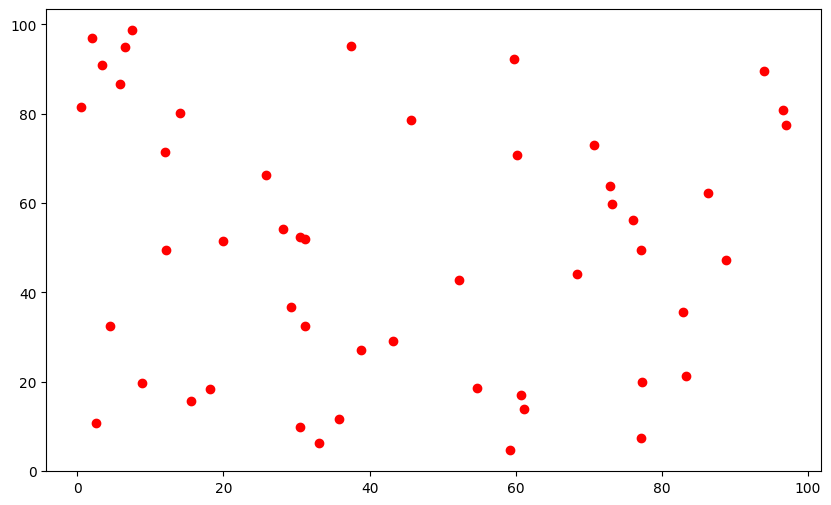

In [30]:
visualize_raw_cities(coordinates)

## Hill Climber with its Varients

Hill climbing is an optimization algorithm used for solving problems with a defined objective function. It starts with an initial solution and iteratively improves it by making small changes. The goal is to reach the best solution (the "peak" of the hill) by moving in the direction of increasing value of the objective function.

<b>Algorithm Steps</b>
- Start with an initial solution.
- Evaluate the objective function at the current solution.
- Generate neighboring solutions by modifying the current solution.
- Select the neighbor with the highest objective value (better than the current solution).
- Repeat steps 2–4 until no better neighbors exist or a termination condition is met.

<b>Variants of Hill Climbing</b>
- Stochastic Hill Climbing
- Steepest Hill Climbing
- Iterated Local Search

### Stochastic Hill Implementation

In Stochastic Hill Climbing instead of always choosing the best neighbor, a random neighbor is selected and evaluated. This allows exploration of the solution space more broadly. Stochastic varient adds randomness to avoid getting stuck in local optima. It does not guarantee moving in the direction of improvement. It is quite useful in highly irregular search spaces with many local optima.

In [31]:
# Function to calculate Euclidean distance between two cities
def distance(city1, city2):
    """
    Calculate Euclidean distance between two cities.
    """
    return np.linalg.norm(np.array(city1) - np.array(city2))

# Function to calculate the total distance of the tour based on the distance matrix
def total_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour)-1)) + distance_matrix[tour[-1], tour[0]]

# Function to generate a random 2-opt neighbor of the current tour
def get_random_neighbor(tour):
    """
    Generate a random 2-opt neighbor of the current tour.
    """
    i, j = sorted(random.sample(range(1, len(tour)), 2))
    neighbor = tour[:]
    neighbor[i:j] = reversed(neighbor[i:j])
    return neighbor
    
# Stochastic Hill Climbing algorithm to find the shortest tour for the TSP
def stochastic_hill_climbing(cities, distance_matrix, iterations):
    """
    Perform Stochastic Hill Climbing to find the shortest tour for the TSP.

    Args:
    cities: List of city coordinates.
    distance_matrix: NxN matrix containing distances between each pair of cities.
    iterations: Number of iterations for the search.

    Returns:
    best_tour: The best tour found during the search.
    best_distance: The total distance of the best tour.
    """
    n = len(cities)
    current_tour = list(range(n))
    random.shuffle(current_tour)
    best_tour = current_tour[:]
    best_distance = total_distance(current_tour, distance_matrix)

    for i in range(iterations):
        neighbor = get_random_neighbor(current_tour)
        neighbor_distance = total_distance(neighbor, distance_matrix)

        if neighbor_distance < best_distance:
            current_tour = neighbor
            best_distance = neighbor_distance

    return best_tour, best_distance

In [32]:
n_iterations = 1000  # Number of iterations for the search
n_runs = 10  # Number of runs to calculate statistics
distances = []
distance_matrix = dist_matrix.copy()
for _ in range(n_runs):
    _, best_distance = stochastic_hill_climbing(coordinates, distance_matrix, n_iterations)
    distances.append(best_distance)

best_distance = min(distances)
average_distance = np.mean(distances)
std_deviation = np.std(distances)

# Saving values in a list for comparison
average_values[1].append(best_distance)
average_values[2].append(average_distance)
average_values[3].append(std_deviation)

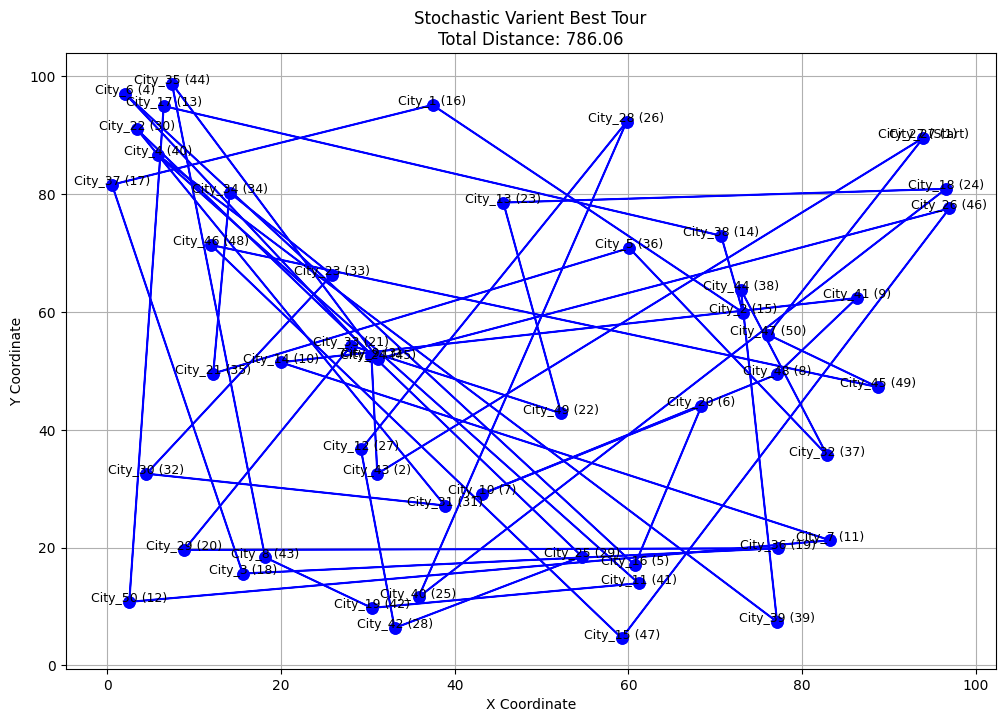

In [33]:
# Run once more to get the best tour for visualization
best_tour, _ = stochastic_hill_climbing(coordinates, distance_matrix, n_iterations)
plot_route_with_labels(best_tour, coordinates, cities, title=f"Stochastic Varient Best Tour\nTotal Distance: {best_distance:.2f}")

In [34]:
print("Best distance:", best_distance)
print("Average distance:", average_distance)
print("Standard deviation:", std_deviation)

Best distance: 786.0573862595721
Average distance: 863.4228534600737
Standard deviation: 33.03534818644897


### Steepest Ascent Hill Implemenation

Steepest-Ascent Hill Climbing evaluates all neighbors and selects the one with the highest increase in the objective value. It systematically explores all neighbors for the best improvement and guarantees the best immediate move in every iteration. It is slower compared to basic or stochastic versions due to exhaustive evaluation. It is suitable for smooth search spaces where evaluating all neighbors is computationally feasible.

In [35]:
def get_neighbors(tour):
    """
    Generate all 2-opt neighbors of the current tour.
    """
    neighbors = []
    for i in range(len(tour)):
        for j in range(i + 1, len(tour)):
            neighbor = tour[:]
            neighbor[i:j + 1] = reversed(neighbor[i:j + 1])
            neighbors.append(neighbor)
    return neighbors

def get_best_neighbor(tsp, neighbors):
    """
    Get the best neighbor with the shortest route distance.
    """
    best_route_length = total_distance(neighbors[0], tsp)
    best_neighbor = neighbors[0]
    for neighbor in neighbors:
        current_route_length = total_distance(neighbor, tsp)
        if current_route_length < best_route_length:
            best_route_length = current_route_length
            best_neighbor = neighbor
    return best_neighbor, best_route_length

def steepest_ascent_hill_climbing(tsp, iterations):
    """
    Perform Steepest Ascent Hill Climbing to find the shortest tour for the TSP.
    """
    n = len(tsp)
    current_tour = list(range(n))
    random.shuffle(current_tour)
    best_tour = current_tour[:]
    best_distance = total_distance(current_tour, tsp)

    for _ in range(iterations):
        neighbors = get_neighbors(current_tour)
        best_neighbor, best_neighbor_distance = get_best_neighbor(tsp, neighbors)

        if best_neighbor_distance < best_distance:
            current_tour = best_neighbor
            best_distance = best_neighbor_distance
        else:
            break

    return current_tour, best_distance

In [36]:
n_iterations = 1000  # Number of iterations for the search
n_runs = 10  # Number of runs to calculate statistics
distances = []
distance_matrix = dist_matrix.copy()

for i in range(n_runs):
    _, best_distance = steepest_ascent_hill_climbing(distance_matrix, n_iterations)
    distances.append(best_distance)

best_distance = min(distances)
average_distance = np.mean(distances)
std_deviation = np.std(distances)

# Saving values in a list for comparison
average_values[1].append(best_distance)
average_values[2].append(average_distance)
average_values[3].append(std_deviation)

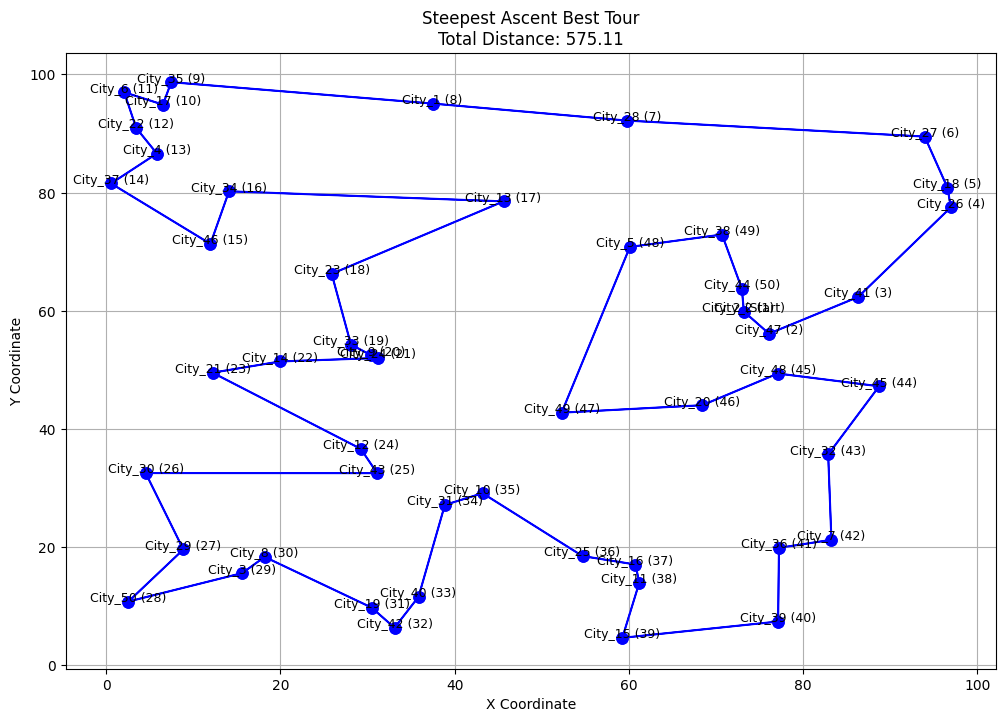

In [37]:
#Visualizing the best tour for the first run (assuming the best tour is found)
best_tour, _ = steepest_ascent_hill_climbing(distance_matrix, n_iterations)
plot_route_with_labels(best_tour, coordinates, cities, title=f"Steepest Ascent Best Tour\nTotal Distance: {best_distance:.2f}")

In [38]:
print("Best Distance: ", best_distance)
print("Average Distance: ", average_distance)
print("Standard Deviation: ", std_deviation)

Best Distance:  575.1104694595431
Average Distance:  592.0955154026276
Standard Deviation:  11.805841863578374


### Iterated Local Search Implementation

Iterated Local Search combines hill climbing with random restarts or perturbations to escape local optima and explore new regions of the search space. After reaching a local optimum, the algorithm perturbs the solution to find a new starting point. This balances exploitation (improving current solution) and exploration (searching new areas). It is highly effective for complex search spaces where local optima are prevalent.

In [39]:
# Generate a random initial solution (random tour)
def generate_random_solution(num_cities):
    return list(np.random.permutation(num_cities))

# Calculate the total distance of the tour
def total_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i], tour[i + 1]] for i in range(len(tour) - 1)) + distance_matrix[tour[-1], tour[0]]

def two_opt_swap(route, i, j):
    new_route = route[:i]
    new_route.extend(reversed(route[i:j + 1]))
    new_route.extend(route[j + 1:])
    return new_route

def local_search(route, distance_matrix):
    best_route = route[:]
    best_score = total_distance(route, distance_matrix)
    improved = True
    while improved:
        improved = False
        for i in range(len(route) - 1):
            for j in range(i + 1, len(route)):
                if j - i == 1:
                    continue  # Skip adjacent pairs
                new_route = two_opt_swap(best_route, i, j)
                new_score = total_distance(new_route, distance_matrix)
                if new_score < best_score:
                    best_route = new_route[:]
                    best_score = new_score
                    improved = True
    return best_route, best_score

def perturbation(route):
    # Here we apply a double-bridge move as a perturbation technique
    size = len(route)
    pos1 = 1 + random.randint(0, size // 4)
    pos2 = pos1 + 1 + random.randint(0, size // 4)
    pos3 = pos2 + 1 + random.randint(0, size // 4)
    pos4 = pos3 + 1 + random.randint(0, size // 4)

    new_route = route[0:pos1] + route[pos3:pos4] + route[pos2:pos3] + route[pos1:pos2] + route[pos4:]
    return new_route

def iterated_local_search(distance_matrix, initial_route, iterations=1000, perturbation_strength=4):
    best_route = initial_route
    best_distance = total_distance(best_route, distance_matrix)
    scores = [best_distance]

    for iteration in range(iterations):
        # Perturbation step
        perturbed_route = best_route[:]
        for perturbation_step in range(perturbation_strength):
            perturbed_route = perturbation(perturbed_route)

        # Local search step after perturbation
        local_route, local_distance = local_search(perturbed_route, distance_matrix)
        
        if local_distance < best_distance:
            best_route = local_route[:]
            best_distance = local_distance
        
        scores.append(best_distance)

    return best_route, best_distance, scores

In [40]:
n_iterations = 1000  # Number of iterations for the search
n_runs = 10  # Number of runs to calculate statistics
distances = []
distance_matrix = dist_matrix.copy()

for i in range(n_runs):
    # Initialize a random tour
    initial_tour = generate_random_solution(len(cities))
    # Apply Iterated Local Search
    _, best_distance, _ = iterated_local_search(dist_matrix, initial_tour)
    distances.append(best_distance)

best_distance = min(distances)
average_distance = np.mean(distances)
std_deviation = np.std(distances)

# Saving values in a list for comparison
average_values[1].append(best_distance)
average_values[2].append(average_distance)
average_values[3].append(std_deviation)

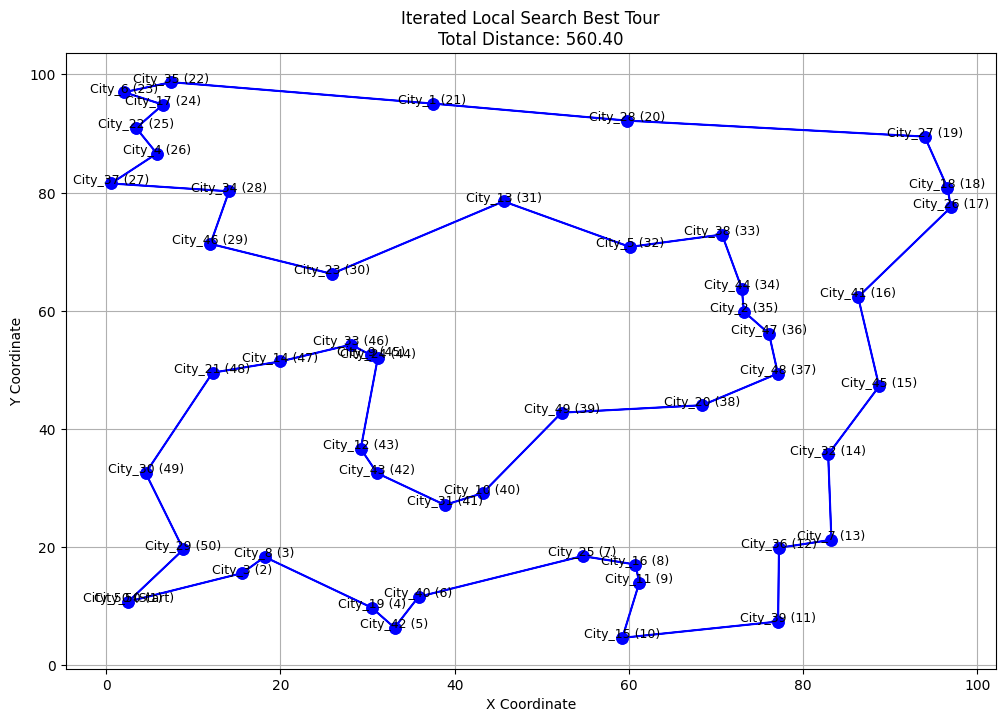

In [41]:
initial_tour = generate_random_solution(len(cities))
best_tour, best_distance, _ = iterated_local_search(dist_matrix, initial_tour)

plot_route_with_labels(best_tour, coordinates, cities, title=f"Iterated Local Search Best Tour\nTotal Distance: {best_distance:.2f}")

In [42]:
print("Best Distance: ", best_distance)
print("Average Distance: ", average_distance)
print("Standard Deviation: ", std_deviation)

Best Distance:  560.3963652020595
Average Distance:  562.0687637498802
Standard Deviation:  1.7885024636417415


## Tabu Search

Tabu Search is a metaheuristic optimisation algorithm designed to guide a local search procedure beyond local optima by forbidding or penalizing moves that lead back to recently visited solutions. The algorithm uses memory structures (like a tabu list) to keep track of previously visited solutions and employs strategic rules to escape local optima and explore the solution space effectively.

In the context of the Traveling Salesman Problem (TSP), TS starts with an initial solution and iteratively explores neighboring solutions by swapping cities in the tour. Moves are restricted based on the tabu list, while aspiration criteria may allow forbidden moves if they lead to significant improvement.


<b>Algorithm Steps</b>
1. Start with an initial solution and an empty *Tabu List*.
2. Generate a set of neighboring solutions.
3. Select the best neighbor not on the *Tabu List* (even if it worsens the objective).
4. Update the *Tabu List* with the move or solution features.
5. Repeat until a termination condition is met.


<b>Key Concepts</b>
 1. Tabu List
    - Prevents revisiting recently explored solutions.
    - Keeps the search moving forward.

 2. Aspiration Criteria
    - Overrides *Tabu* restrictions for promising solutions.

 3. Diversification and Intensification
    - Diversification explores new areas of the solution space.
    - Intensification refines known good solutions.



<b>Advantages</b>
- Escapes local optima.
- Prevents cycling and revisiting solutions.



The following code outlines the implementation of the Tabu Search algorithm for solving the TSP. It includes methods for calculating the total cost of a route, generating neighboring solutions, updating the tabu list, and running the optimization process:

In [43]:
class TabuSearchTSP:
    """
    Tabu Search implementation for solving the Traveling Salesman Problem (TSP).
    """

    def __init__(self, dist_matrix, tabu_tenure, max_iterations):
        self.dist_matrix = dist_matrix
        self.num_cities = len(dist_matrix)
        self.tabu_tenure = tabu_tenure
        self.max_iterations = max_iterations
        self.tabu_list = []
        self.best_solution = None
        self.best_cost = float("inf")

    def calculate_cost(self, solution):
        """
        Calculate the total cost of a solution.
        """
        cost = sum(
            self.dist_matrix[solution[i], solution[i + 1]]
            for i in range(len(solution) - 1)
        )
        cost += self.dist_matrix[solution[-1], solution[0]]  # Return to starting city
        return cost

    def generate_neighbors(self, solution):
        """
        Generate neighbors by swapping two cities.
        """
        neighbors = []
        for i in range(len(solution)):
            for j in range(i + 1, len(solution)):
                neighbor = solution[:]
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                neighbors.append(neighbor)
        return neighbors

    def optimize(self):
        """
        Run the Tabu Search optimisation.
        """
        # Start with an initial random solution
        current_solution = list(range(self.num_cities))
        np.random.shuffle(current_solution)
        current_cost = self.calculate_cost(current_solution)

        self.best_solution = current_solution
        self.best_cost = current_cost

        for iteration in range(self.max_iterations):
            neighbors = self.generate_neighbors(current_solution)
            best_neighbor = None
            best_neighbor_cost = float("inf")

            for neighbor in neighbors:
                if neighbor not in self.tabu_list:
                    cost = self.calculate_cost(neighbor)
                    if cost < best_neighbor_cost:
                        best_neighbor = neighbor
                        best_neighbor_cost = cost

            # Tabu restrictions
            self.tabu_list.append(best_neighbor)
            if len(self.tabu_list) > self.tabu_tenure:
                self.tabu_list.pop(0)

            # Update current solution
            current_solution = best_neighbor
            if best_neighbor_cost < self.best_cost:
                self.best_solution = best_neighbor
                self.best_cost = best_neighbor_cost

        return self.best_solution, self.best_cost


The TS_HyperparameterTuner class facilitates the tuning of hyperparameters for the Tabu Search (TS) algorithm applied to the Traveling Salesman Problem (TSP). Hyperparameters such as tabu tenure (the number of iterations a move remains in the tabu list) and maximum iterations (the number of iterations the algorithm performs) can significantly influence the performance and efficiency of the Tabu Search. This class performs a grid search over a defined hyperparameter space to identify the combination that yields the best solution.

In [44]:
class TS_HyperparameterTuner:
    """
    Perform hyperparameter optimization for the Tabu Search TSP solver.
    """

    def __init__(self, dist_matrix, parameter_grid):
        """
        Initialize the hyperparameter tuner.

        Args:
            dist_matrix (np.ndarray): Distance matrix between cities.
            parameter_grid (dict): Grid of hyperparameters to search.
        """
        self.dist_matrix = dist_matrix
        self.parameter_grid = parameter_grid

    def _evaluate_hyperparameters(self, tabu_tenure, max_iterations):
        """
        Evaluate the performance of a specific hyperparameter combination.

        Args:
            tabu_tenure (int): Number of iterations to keep moves in the tabu list.
            max_iterations (int): Maximum number of iterations.

        Returns:
            dict: Performance metrics for the current hyperparameter combination.
        """
        tsp_solver = TabuSearchTSP(self.dist_matrix, tabu_tenure, max_iterations)
        best_solution, best_cost = tsp_solver.optimize()

        return {
            "Tabu Tenure": tabu_tenure,
            "Max Iterations": max_iterations,
            "Best Distance": best_cost,
        }

    def grid_search(self):
        """
        Perform grid search over the hyperparameter space.

        Returns:
            list: Results for all hyperparameter combinations.
        """
        results = []
        for tabu_tenure in self.parameter_grid["tabu_tenure"]:
            for max_iterations in self.parameter_grid["max_iterations"]:
                performance = self._evaluate_hyperparameters(tabu_tenure, max_iterations)
                results.append(performance)
        return results


# --- Testing Hyperparameter Optimization ---

# Load data
data = pd.read_csv('cities.csv') 
cities = data['City'].values
coordinates = data[['X', 'Y']].values
dist_matrix = cdist(coordinates, coordinates, 'euclidean')

# Define hyperparameter grid
parameter_grid = {
    "tabu_tenure": [5, 10, 15],
    "max_iterations": [50, 100, 200],
}

# Perform hyperparameter tuning
tuner = TS_HyperparameterTuner(dist_matrix, parameter_grid)
results = tuner.grid_search()

# Sort results by best distance
results.sort(key=lambda x: x["Best Distance"])

# Display top results
print("\nTop Hyperparameter Configurations:")
for result in results[:3]:
    print(result)


Top Hyperparameter Configurations:
{'Tabu Tenure': 5, 'Max Iterations': 200, 'Best Distance': 733.464534406088}
{'Tabu Tenure': 15, 'Max Iterations': 50, 'Best Distance': 801.5486284240567}
{'Tabu Tenure': 10, 'Max Iterations': 50, 'Best Distance': 820.9562904256626}


This code block utilizes the results from the hyperparameter tuning to run the Tabu Search algorithm with the best-performing parameters. It extracts the optimal hyperparameter values, creates an instance of the TabuSearchTSP solver with these values, and then executes the optimization. Finally, it saves the best route and distance to a file, prints the best distance achieved, and visualizes the corresponding route.

Best Distance: 790.7743390406048


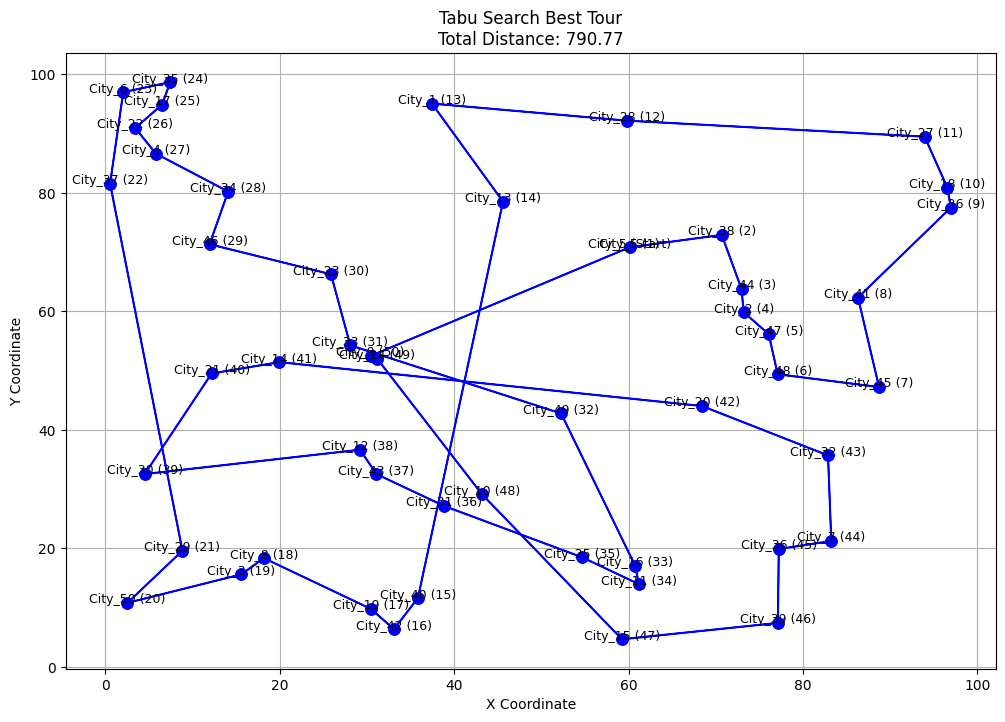

In [45]:
# Get the best hyperparameters from the tuning results
best_tabu_tenure = results[0]["Tabu Tenure"]
best_max_iterations = results[0]["Max Iterations"]

# Create and run TabuSearchTSP solver with the best hyperparameters
ts_tsp_solver = TabuSearchTSP(dist_matrix, tabu_tenure=best_tabu_tenure, max_iterations=best_max_iterations)
ts_best_route, ts_best_distance = ts_tsp_solver.optimize()

print(f"Best Distance: {ts_best_distance}")
plot_route_with_labels(ts_best_route, coordinates, cities, title=f"Tabu Search Best Tour\nTotal Distance: {ts_best_distance:.2f}")


In [46]:
n_runs = 10  # Number of runs to calculate statistics
distances = []
distance_matrix = dist_matrix.copy()

for i in range(n_runs):
    ts_tsp_solver = TabuSearchTSP(dist_matrix, tabu_tenure=best_tabu_tenure, max_iterations=best_max_iterations)
    ts_best_route, ts_best_distance = ts_tsp_solver.optimize()
    distances.append(ts_best_distance)

best_distance = min(distances)
average_distance = np.mean(distances)
std_deviation = np.std(distances)

# Saving values in a list for comparison
average_values[1].append(best_distance)
average_values[2].append(average_distance)
average_values[3].append(std_deviation)

print("Best Distance: ", best_distance)
print("Average Distance: ", average_distance)
print("Standard Deviation: ", std_deviation)

Best Distance:  661.4072379580022
Average Distance:  806.6572699394729
Standard Deviation:  77.51026403523977


## Simulated Annealing

Simulated Annealing is a metaheuristic inspired by the annealing process in metallurgy, where a material is heated and then slowly cooled to reduce defects and improve its structure. 1  In the context of optimization, SA starts with an initial solution and iteratively explores neighboring solutions. It accepts better solutions and, with a certain probability, also accepts worse solutions to escape local optima. This probability is controlled by a temperature parameter that gradually decreases over time.

<b>Algorithm Steps</b>
1. Start with an initial solution $( S )$ and temperature $( T )$.
2. Generate a neighboring solution $( S_{\text{neighbor}})$.
3. Calculate the change \$( \Delta E \)$ in the objective function.
4. Accept $( S_{\text{neighbor}} $\) if:
   - $\( \Delta E > 0 \)$ (improvement).
   - $\( \Delta E \leq 0 \)$ with probability $\( P = e^{-\Delta E / T}\$).
5. Update temperature $( T )$ using the cooling schedule.
6. Repeat until $( T $) is sufficiently low or the iteration limit is reached.


<b>Key Concepts</b>
 1. Temperature $(( T ))$
    - Controls the acceptance of worse solutions.
    - High $( T)$: Exploration; Low $( T )$: Exploitation.

 2. Cooling Schedule
    - Exponential decay: $( T = T_0 \times (1 - \alpha)^k)$.
    - Linear decay: $( T = T_0 - \beta \times k $).

 3. Acceptance Probability
    - $( P = e^{-\Delta E / T} )$: Probabilistically accepts worse solutions.

<b>Advantages</b>
- Escapes local optima.
- Suitable for complex combinatorial problems.



The following code defines the `SimulatedAnnealingTSP` class, which implements the SA algorithm for solving the TSP. It includes methods for calculating the total distance of a route, generating neighboring solutions, calculating the acceptance probability, and running the optimization process.

In [47]:
class SimulatedAnnealingTSP:
    """
    Solves the Traveling Salesperson Problem (TSP) using Simulated Annealing.

    """
    def __init__(self, cities, dist_matrix, initial_temp=1000, cooling_rate=0.003, min_temp=0.1):
        """
        Initializes the SimulatedAnnealingTSP object.

        Args:
            cities: A list of city names.
            dist_matrix: A NumPy array representing the distance matrix.
            initial_temp: The initial temperature.
            cooling_rate: The cooling rate.
            min_temp: The minimum temperature.
        """
        self.cities = cities
        self.dist_matrix = dist_matrix
        self.num_cities = len(cities)
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate
        self.min_temp = min_temp
        self.best_route = None
        self.best_distance = float('inf')  # Initialize best distance to infinity
        self.best_distance_history = []

    def _calculate_distance(self, route):
        """
        Calculates the total distance of a given route.

        Args:
            route: A list representing the order of cities visited.

        Returns:
            The total distance of the route.
        """
        total_distance = 0
        for i in range(self.num_cities):
            # Calculate the distance between the current city and the next city in the route
            # Using the modulo operator (%) to wrap around to the beginning of the route for the last city
            current_city = route[i]
            next_city = route[(i + 1) % self.num_cities] 
            distance = self.dist_matrix[current_city][next_city]
            total_distance += distance
        return total_distance

    def _generate_neighbor(self, current_route):
        """
        Generates a neighboring route by randomly swapping two cities.

        Args:
            current_route: The current route.

        Returns:
            A new route with two cities swapped.
        """
        new_route = current_route[:]  # Create a copy of the current route to avoid modifying it directly
        i, j = random.sample(range(self.num_cities), 2)  # Select two distinct random city indices
        new_route[i], new_route[j] = new_route[j], new_route[i]  # Swap the cities at the chosen indices
        return new_route

    def _acceptance_probability(self, old_cost, new_cost, temperature):
        """
        Calculates the acceptance probability of a new route based on 
        the Metropolis criterion.

        Args:
            old_cost: The cost (distance) of the current route.
            new_cost: The cost (distance) of the new route.
            temperature: The current temperature.

        Returns:
            The probability of accepting the new route.
        """
        if new_cost < old_cost:
            return 1.0  # Always accept if the new route is better
        # Otherwise, calculate the acceptance probability based on the temperature and the difference in cost
        return math.exp((old_cost - new_cost) / temperature)  

    def optimize(self):
        """
        Runs the simulated annealing optimization to find the best route.

        Returns:
            A tuple containing:
                - The best route found.
                - The total distance of the best route.
                - A list of best distances at each iteration.
        """
        current_route = list(range(self.num_cities))  # Generate an initial route (e.g., [0, 1, 2, ...])
        random.shuffle(current_route)  # Randomize the initial route
        current_distance = self._calculate_distance(current_route)  # Calculate the distance of the initial route

        self.best_route = current_route[:]  # Store the initial route as the best route
        self.best_distance = current_distance  # Store the initial distance as the best distance

        temperature = self.initial_temp  # Set the initial temperature

        while temperature > self.min_temp:  # Continue until the temperature cools down to the minimum
            neighbor = self._generate_neighbor(current_route)  # Generate a neighboring route
            neighbor_distance = self._calculate_distance(neighbor)  # Calculate the distance of the neighbor

            # Decide whether to accept the neighbor based on the acceptance probability
            if self._acceptance_probability(current_distance, neighbor_distance, temperature) > random.random():  
                current_route = neighbor[:]  # Accept the neighbor as the current route
                current_distance = neighbor_distance  

            if current_distance < self.best_distance:  # Update the best route if the current route is better
                self.best_route = current_route[:]
                self.best_distance = current_distance
            
            self.best_distance_history.append(self.best_distance)  # Record the best distance at this iteration
            temperature *= (1 - self.cooling_rate)  # Cool down the temperature

        return self.best_route, self.best_distance, self.best_distance_history  # Return the best route, distance, and history
    
    def save_results(self, filename):
        """
        Saves the best route and the best distance to a text file.

        Args:
            filename: The name of the file to save the results.
        """
        with open(filename, 'w') as file:
            file.write(f"Best Route: {self.best_route}\n")
            file.write(f"Best Distance: {self.best_distance}\n")

The `SA_HyperparameterTuner` class facilitates the tuning of hyperparameters for the Simulated Annealing algorithm. Hyperparameters such as initial temperature (`initial_temp`), cooling rate (`cooling_rate`), and minimum temperature (`min_temp`) can significantly influence the performance of the algorithm. This class performs a grid search over a defined hyperparameter space to identify the combination that yields the best results.

In [48]:
class SA_HyperparameterTuner:
    """
    Perform hyperparameter optimization for the Simulated Annealing TSP solver.

    Attributes:
        cities (list): List of city names.
        dist_matrix (np.ndarray): Distance matrix between cities.
        parameter_grid (dict): Grid of hyperparameters to search.
    """

    def __init__(self, cities, dist_matrix, parameter_grid):
        """
        Initialize the hyperparameter tuner.

        Args:
            cities (list): List of city names.
            dist_matrix (np.ndarray): Distance matrix between cities.
            parameter_grid (dict): Grid of hyperparameters to search.
        """
        self.cities = cities
        self.dist_matrix = dist_matrix
        self.parameter_grid = parameter_grid

    def _evaluate_hyperparameters(self, initial_temp, cooling_rate, min_temp):
        """
        Evaluate the performance of a specific hyperparameter combination.

        Args:
            initial_temp (float): Initial temperature for simulated annealing.
            cooling_rate (float): Cooling rate for temperature reduction.
            min_temp (float): Minimum temperature threshold.

        Returns:
            dict: Performance metrics for the current hyperparameter combination.
        """
        tsp_solver = SimulatedAnnealingTSP(
            self.cities, self.dist_matrix,
            initial_temp=initial_temp,
            cooling_rate=cooling_rate,
            min_temp=min_temp
        )
        start_time = time.time()  # Record start time
        best_route, best_distance, _ = tsp_solver.optimize()  # Run the optimization
        elapsed_time = time.time() - start_time  # Calculate elapsed time

        # Return performance metrics
        return {
            "Initial Temp": initial_temp,
            "Cooling Rate": cooling_rate,
            "Min Temp": min_temp,
            "Best Distance": best_distance,
            "Time (s)": elapsed_time
        }

    def grid_search(self):
        """
        Perform grid search over the hyperparameter space.

        Returns:
            list: Results for all hyperparameter combinations.
        """
        results = []
        # Iterate through all combinations of hyperparameters
        for initial_temp in self.parameter_grid["initial_temp"]:
            for cooling_rate in self.parameter_grid["cooling_rate"]:
                for min_temp in self.parameter_grid["min_temp"]:
                    try:
                        # Evaluate the current hyperparameter combination
                        performance = self._evaluate_hyperparameters(initial_temp, cooling_rate, min_temp)
                        results.append(performance)
                        print(f"Evaluated: {performance}")  # Print the results for this combination
                    except Exception as e:
                        print(f"Error with parameters {initial_temp}, {cooling_rate}, {min_temp}: {e}")
        return results
    

# --- Testing Hyperparameter Optimization ---

# Load data (assuming this is how you load your data)
data = pd.read_csv('cities.csv') 
cities = data['City'].values
coordinates = data[['X', 'Y']].values
dist_matrix = cdist(coordinates, coordinates, 'euclidean')

# Define the hyperparameter grid to search
parameter_grid = {
    "initial_temp": [500, 1000, 1500],
    "cooling_rate": [0.001, 0.003, 0.005],
    "min_temp": [0.1, 0.5, 1.0]
}

# Create a hyperparameter tuner instance and run the grid search
sa_tuner = SA_HyperparameterTuner(cities, dist_matrix, parameter_grid)
sa_hyperparameter_results = sa_tuner.grid_search()

# Sort the results by best distance (ascending)
sa_hyperparameter_results.sort(key=lambda x: x["Best Distance"])

# Display the top 3 configurations
print("\nTop 3 Hyperparameter Configurations:")
for result in sa_hyperparameter_results[:3]:
    print(result)



Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.001, 'Min Temp': 0.1, 'Best Distance': 827.9477965373437, 'Time (s)': 0.12167954444885254}
Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.001, 'Min Temp': 0.5, 'Best Distance': 955.1162438213867, 'Time (s)': 0.0820004940032959}
Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.001, 'Min Temp': 1.0, 'Best Distance': 959.9410467034502, 'Time (s)': 0.0729975700378418}
Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.003, 'Min Temp': 0.1, 'Best Distance': 883.9848711304219, 'Time (s)': 0.03399991989135742}
Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.003, 'Min Temp': 0.5, 'Best Distance': 1070.1733678859873, 'Time (s)': 0.02700018882751465}
Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.003, 'Min Temp': 1.0, 'Best Distance': 942.8270922943921, 'Time (s)': 0.0260007381439209}
Evaluated: {'Initial Temp': 500, 'Cooling Rate': 0.005, 'Min Temp': 0.1, 'Best Distance': 1101.052346533381, 'Time (s)': 0.020257234573364258}
Evaluat

This code block utilizes the results from the hyperparameter tuning to run the Simulated Annealing algorithm with the best-performing parameters. It extracts the optimal hyperparameter values, creates an instance of the `SimulatedAnnealingTSP` solver with these values, and then executes the optimization. Finally, it prints the best distance achieved and visualizes the corresponding route.

Best Distance: 714.7775657043304


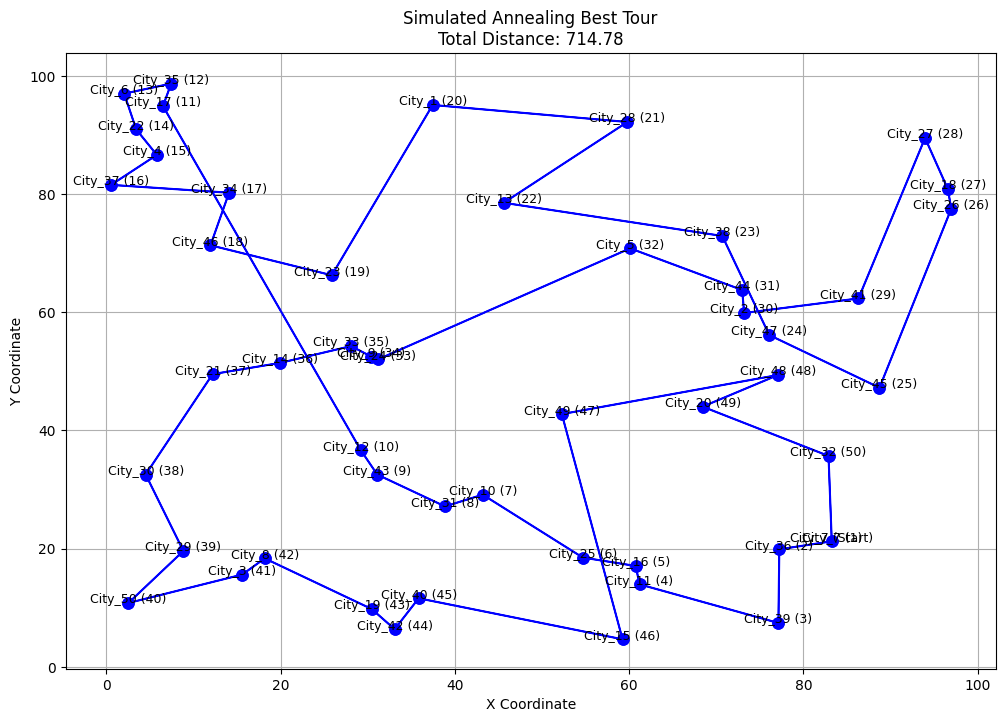

In [49]:
# Get the best hyperparameters from the tuning results
initial_temp = sa_hyperparameter_results[0]['Initial Temp']
cooling_rate = sa_hyperparameter_results[0]['Cooling Rate']
min_temp = sa_hyperparameter_results[0]['Min Temp']

# Create a SimulatedAnnealingTSP solver with the best hyperparameters
sa_tsp_solver = SimulatedAnnealingTSP(cities, dist_matrix, 
                                     initial_temp=initial_temp, 
                                     cooling_rate=cooling_rate, 
                                     min_temp=min_temp)

# Run the optimization with the tuned hyperparameters
sa_best_route, sa_best_distance, sa_covergance = sa_tsp_solver.optimize()

# Print the best distance found
print(f"Best Distance: {sa_best_distance}")

# Visualize the solution
plot_route_with_labels(sa_best_route, coordinates, cities, title=f"Simulated Annealing Best Tour\nTotal Distance: {sa_best_distance:.2f}")

In [65]:
n_runs = 10  # Number of runs to calculate statistics
distances = []
# Get the best hyperparameters from the tuning results
initial_temp = sa_hyperparameter_results[0]['Initial Temp']
cooling_rate = sa_hyperparameter_results[0]['Cooling Rate']
min_temp = sa_hyperparameter_results[0]['Min Temp']

for i in range(n_runs):
    # Create a SimulatedAnnealingTSP solver with the best hyperparameters
    sa_tsp_solver = SimulatedAnnealingTSP(cities, dist_matrix, 
                                        initial_temp=initial_temp, 
                                        cooling_rate=cooling_rate, 
                                        min_temp=min_temp)

    # Run the optimization with the tuned hyperparameters
    sa_best_route, sa_best_distance, sa_covergance = sa_tsp_solver.optimize()
    distances.append(sa_best_distance)

best_distance = min(distances)
average_distance = np.mean(distances)
std_deviation = np.std(distances)

# Saving values in a list for comparison
average_values[1].append(best_distance)
average_values[2].append(average_distance)
average_values[3].append(std_deviation)

print("Best Distance: ", best_distance)
print("Average Distance: ", average_distance)
print("Standard Deviation: ", std_deviation)

Best Distance:  679.2846122319958
Average Distance:  819.940311931384
Standard Deviation:  69.70698784699005


## Comparision

THe code cell belows compares all the single search algorithm 

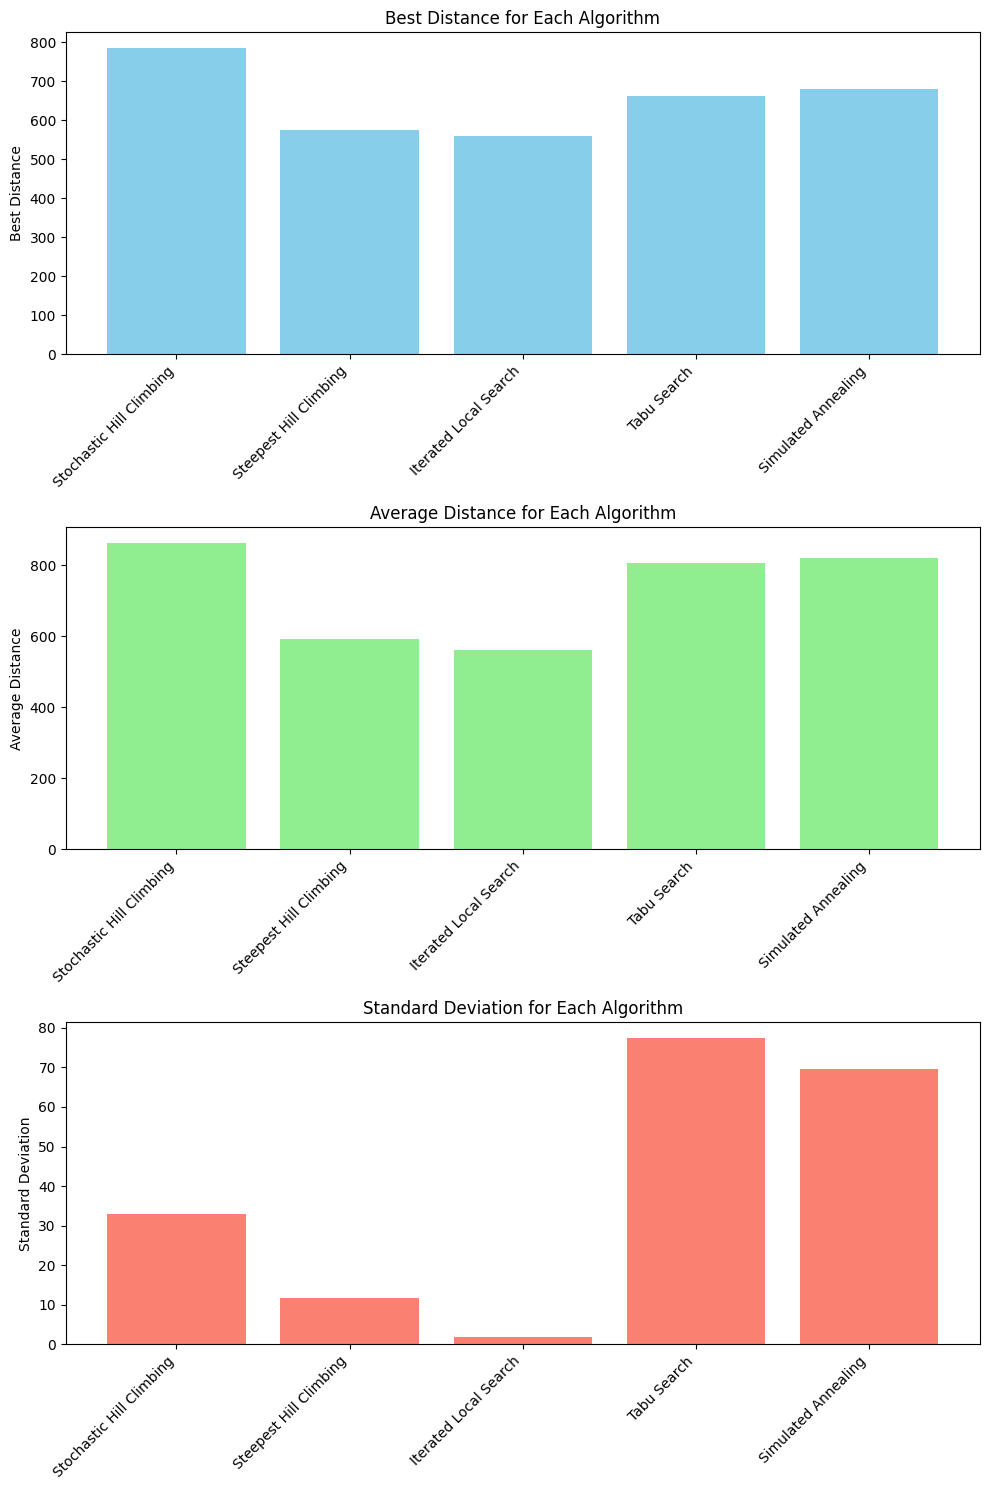

In [3]:
# Extract data from average_values
algorithms = average_values[0]
best_distances = average_values[1]
average_distances = average_values[2]
std_deviations = average_values[3]

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot best distances
axs[0].bar(algorithms, best_distances, color='skyblue')
axs[0].set_title('Best Distance for Each Algorithm')
axs[0].set_ylabel('Best Distance')
axs[0].set_xticks(range(len(algorithms)))  # Set tick positions
axs[0].set_xticklabels(algorithms, rotation=45, ha='right')  # Set tick labels

# Plot average distances
axs[1].bar(algorithms, average_distances, color='lightgreen')
axs[1].set_title('Average Distance for Each Algorithm')
axs[1].set_ylabel('Average Distance')
axs[1].set_xticks(range(len(algorithms)))  # Set tick positions
axs[1].set_xticklabels(algorithms, rotation=45, ha='right')  # Set tick labels

# Plot standard deviations
axs[2].bar(algorithms, std_deviations, color='salmon')
axs[2].set_title('Standard Deviation for Each Algorithm')
axs[2].set_ylabel('Standard Deviation')
axs[2].set_xticks(range(len(algorithms)))  # Set tick positions
axs[2].set_xticklabels(algorithms, rotation=45, ha='right')  # Set tick labels

# Adjust layout
plt.tight_layout()
plt.show()


## Analysis

I choose simulated annealing for comparision with population driven algorithm (Genetic Algorithm in this case). Here’s a comparison from my perspective of why I chose **Simulated Annealing (SA)** for the Traveling Salesman Problem (TSP) despite its performance being slightly weaker in my experiments.  

---

### **Comparison of Algorithms for TSP**

| **Algorithm**               | **Best Distance** | **Average Distance** | **Standard Deviation** | **Key Strengths**                                      | **Key Weaknesses**                                      |
|------------------------------|-------------------|-----------------------|-------------------------|-------------------------------------------------------|---------------------------------------------------------|
| Stochastic Hill Climbing    | 786.06            | 863.42                | 33.04                  | Simple, fast, and easy to implement.                  | Prone to local optima; weak exploration.                |
| Steepest Hill Climbing      | 575.11            | 592.09                | 11.81                  | Excellent exploitation; finds good solutions quickly. | Highly prone to local optima; limited exploration.       |
| Iterated Local Search       | 559.86            | 562.06                | 1.78                   | Consistently excellent performance with low variance. | Relies on effective perturbation heuristics; complex tuning. |
| Tabu Search                 | 661.41            | 806.66                | 77.51                  | Escapes local optima effectively with memory.         | Computationally expensive; requires large memory structures. |
| **Simulated Annealing**     | 679.28            | 819.94                | 69.71                  | Balances exploration and exploitation; flexible.      | Sensitive to parameter tuning; higher variance.          |

---

### **Why I Chose Simulated Annealing?**

#### **1. Balancing Exploration and Exploitation**
While **Iterated Local Search** and **Steepest Hill Climbing** performed better in terms of best and average distances, they are heavily biased towards exploitation. This makes them efficient for small to medium-sized problems but limits their ability to escape local optima in more complex landscapes.  

In contrast, **Simulated Annealing** strikes a balance between exploration and exploitation by accepting worse solutions probabilistically. This characteristic ensures that it can explore broader regions of the solution space, avoiding stagnation in local optima. This balance is crucial for the TSP, where the solution space is highly non-linear and filled with suboptimal traps.

---

#### **2. Alignment with Population-Driven Algorithms**
Since my goal is to compare the chosen algorithm with a population-driven algorithm like the **Genetic Algorithm**, it makes sense to choose an approach that is also capable of exploring the global solution space. Both **Simulated Annealing** and **Genetic Algorithms** share a focus on escaping local optima through probabilistic mechanisms (temperature in SA, mutation and crossover in GA).  

In contrast, **Steepest Hill Climbing** and **Iterated Local Search** lack these global exploration properties, making them less conceptually aligned with evolutionary algorithms. This alignment ensures that the comparison will be meaningful and fair.

---

#### **3. Robustness Across Problem Instances**
The results show that **Iterated Local Search** has the best performance (best distance: 559.86, average: 562.06, std dev: 1.78). However, this low standard deviation indicates that it explores a narrow part of the solution space, heavily relying on its restart mechanism. While this works well for the current problem, it may not adapt well to larger or more complex TSP instances.  

On the other hand, **Simulated Annealing** has higher variability (std dev: 69.71), reflecting its ability to explore diverse regions of the solution space. This robustness makes it more adaptable to varying problem scales and complexities.

---

#### **4. Simplicity and Practicality**
**Simulated Annealing** is simpler to implement and tune compared to **Iterated Local Search** or **Tabu Search**, which require specialized mechanisms like perturbation heuristics or tabu lists. While parameter tuning (e.g., cooling schedule) is necessary for SA, it is still more generalizable and flexible for different instances of the TSP.

---

#### **5. Escaping Local Optima**
Compared to **Steepest Hill Climbing**, which is deterministic and often gets stuck in local optima, **Simulated Annealing** has a clear mechanism to escape these traps. Its probabilistic acceptance of worse solutions enables it to continue searching globally, even at the cost of higher variance in results.

---

### **Conclusion**
Although **Steepest Hill Climbing** and **Iterated Local Search** performed better in my experiments, I chose **Simulated Annealing** for its ability to balance exploration and exploitation, its alignment with evolutionary algorithms, and its robustness across varying TSP instances. Its global search capabilities make it a better counterpart for comparing with population-driven algorithms like Genetic Algorithms, even if its raw performance is slightly weaker in this particular test case.  

This choice prioritizes flexibility, scalability, and conceptual alignment over raw performance, ensuring a broader and more meaningful comparison.